In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from utility import *

### Data loading

In [2]:
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = to_categorical(np.ravel(y_train))
y_test = to_categorical(np.ravel(y_test))

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

label_names = {
    0: 'plane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)


In [21]:
def preprocess_images(images_set):
    return images_set * 1. / 255   

# Neural Network

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=25,
    horizontal_flip=True,
    vertical_flip=False,
    featurewise_center=True,
    featurewise_std_normalization=True,
    #zca_whitening=True,
    fill_mode='reflect',
    validation_split=0.02
)

train_datagen.fit(x_train)

In [43]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow_addons.layers.maxout import Maxout

def maxout_nn_model(show_summary=False):
    inputs = tf.keras.layers.Input((32, 32, 3))
    
    hidden = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    hidden = tf.keras.layers.MaxPool2D((2,2))(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = Maxout(num_units=16)(hidden)
        
    hidden = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(hidden)
    hidden = tf.keras.layers.MaxPool2D((2,2))(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    #hidden = tf.keras.layers.Dropout(0.1)(hidden)
    hidden = Maxout(num_units=24)(hidden)
    
    hidden = tf.keras.layers.Conv2D(96, (3, 3), activation='relu', padding='same')(hidden)
    hidden = tf.keras.layers.MaxPool2D((2,2))(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    #hidden = tf.keras.layers.Dropout(0.1)(hidden)
    hidden = Maxout(num_units=48)(hidden)
    
    hidden = tf.keras.layers.Conv2D(192, (4, 4), activation='relu', padding='valid')(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    #hidden = tf.keras.layers.Dropout(0.1)(hidden)
    hidden = Maxout(num_units=96)(hidden)
    
    hidden = tf.keras.layers.Flatten()(hidden)
    
    hidden = tf.keras.layers.Dense(256, activation='relu')(hidden)
    hidden = Maxout(num_units=128)(hidden)
    
    outputs = tf.keras.layers.Dense(10, activation='softmax')(hidden)
    
    model = tf.keras.Model(inputs, outputs)
    metrics = [
        tfa.metrics.F1Score(num_classes=10, average="weighted"),
        'accuracy'
    ]
    model.compile(
        optimizer=RMSprop(lr=0.0002),
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    if show_summary:
        print(model.summary())
    
    return model

In [44]:
model = maxout_nn_model(show_summary=True)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
maxout_28 (Maxout)           (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 48)        6960      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 48)          0   

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

save_best = ModelCheckpoint('models/best_weights_final.hdf5', save_best_only=True, monitor='val_f1_score', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.2, patience=5, verbose=1, cooldown=3)

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=64, subset='training'),
    steps_per_epoch=765,
    validation_data=train_datagen.flow(x_train, y_train, batch_size=64, subset='validation'),
    validation_steps=16,
    callbacks=[save_best, reduce_lr],
    epochs=40
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 765 steps, validate for 16 steps
Epoch 1/40
765/765 [==============================] - 28s 36ms/step - loss: 1.5584 - f1_score: 0.4387 - accuracy: 0.4417 - val_loss: 1.2965 - val_f1_score: 0.5139 - val_accuracy: 0.5150
Epoch 2/40
765/765 [==============================] - 25s 33ms/step - loss: 1.2456 - f1_score: 0.5545 - accuracy: 0.5570 - val_loss: 1.1649 - val_f1_score: 0.5780 - val_accuracy: 0.5810
Epoch 3/40
765/765 [==============================] - 25s 33ms/step - loss: 1.1184 - f1_score: 0.5991 - accuracy: 0.6012 - val_loss: 1.1051 - val_f1_score: 0.6210 - val_accuracy: 0.6230
Epoch 4/40
765/765 [==============================] - 25s 32ms/step - loss: 1.0293 - f1_score: 0.6351 - accuracy: 0.6368 - val_loss: 1.0295 - val_f1_score: 0.6471 - val_accuracy: 0.6460
Epoch 5/40
765/765 [==============================] - 23s 31ms/step - loss: 0.9582 - f1_score: 0.6589 - accuracy: 0.6604 - val_loss: 0.9804 - val_f1_score: 0.6394 

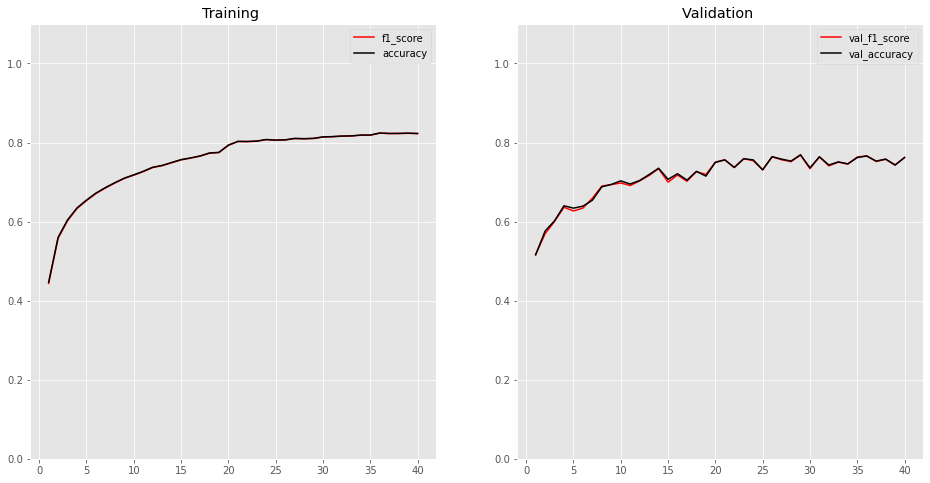

In [20]:
plot_history(history.history)

In [24]:
model.load_weights('models/best_weights_final.hdf5')
x_test_pp = preprocess_images(x_test)
model.evaluate(x_test_pp, y_test)

10000/10000 [==============================] - 2s 195us/sample - loss: 0.7641 - f1_score: 0.7435 - accuracy: 0.7482


[0.7641213726997376, 0.74349034, 0.7482]